# Analysis of the response of olfactory receptors to VOC

## Dataset presentation
### Experimental protocol
- HELA cells were genetically engineered to express a mammalian olfactory receptor on their surface (OR1).
- They also express a range in of proteins allowing their fluorescence level to be correlated to the level of activation this olfactory receptor.
- A population of cells is kept in an incubator in DMSO and maintained for several days before they are dispensed into the wells of a 96-wells plate.
- The plate is inserted into a machine recording fluorescence over time.
- After a few seconds of recording, a certain volume of liquid compounds (VOC: Volatile organic compounds) is dispensed into each well.

### Data organization
The resulting recording files are available in the `data` folder. It contains:
- `plate_map_XXX.csv`: For each well, the olfactory receptor expressed by the HELA cells as well as the injected compound and its concentration (DMSO is a negative control).
- `parameters.txt`: A small text file containing a few acquisition parameters.
- `fluo_data_XX.csv`: The resulting fluorescence versus time for well XX.

### Goal
Our objective is here to determine if the olfactory receptor OR1 is activated by one of the compounds used during the experiment. 

## Data Parsing

In [1]:
# Import the main libraries we will use here
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Data directory
data_dir = Path.cwd() / "data"

### Parameters
Extract the stimulation time (`TransferTime`) and the number of points for each time series (`NPoints`) from parameters.txt, you can for instance use regular expressions.

In [3]:
file_name_parameters = "parameters.txt"
parameter_path = data_dir / file_name_parameters

with parameter_path.open(mode="r") as f:
    parameter_raw = f.readlines()
parameter_raw

['ReadMode="Fluorescence"\n',
 'PlateType="96WP black bottom"\n',
 'TimeTagged="True"\n',
 'Name="Fam1-DoseResponseTest"\n',
 'ReadTime="3:36 PM 9/27/2020"\n',
 'RunTime="2:00"\n',
 'KineticInterval="1.600"\n',
 'NPoints="76"\n',
 'Excitation="430"\n',
 'Emission="485"\n',
 'TransferTime="19"\n',
 'Rate="1"\n',
 'Volume="10"\n',
 'PipetteHeight="80"']

In [4]:
parameters = {}

pattern = '(?P<parameter_name>\w+)="(?P<parameter_value>\w+)"'
for row in parameter_raw:
    my_match = re.search(pattern, row)

    if my_match:
        param_dict = my_match.groupdict()
        parameters[param_dict["parameter_name"]] = param_dict["parameter_value"]
parameters

{'ReadMode': 'Fluorescence',
 'TimeTagged': 'True',
 'NPoints': '76',
 'Excitation': '430',
 'Emission': '485',
 'TransferTime': '19',
 'Rate': '1',
 'Volume': '10',
 'PipetteHeight': '80'}

In [5]:
n_points = int(parameters["NPoints"])
stim_time = float(parameters["TransferTime"])
print(n_points, stim_time)

76 19.0


### Fluorescence and time data
Select the files corresponding to fluorescence data (E.G. using a regular expression on the file name) and create two pandas DataFrame with rows corresponding to the time index and columns corresponding to each well with content:

- A first dataframe containing the time data for each well
- A second dataframe containing the fluorescence data for each well

In [6]:
# Create the names of the columns
plate_rows = ["A", "B", "C", "D", "E", "F", "G", "H"]
plate_columns = [str(i) for i in range(1, 13)]
plate_wells = [r + c for r in plate_rows for c in plate_columns]
print(plate_wells)

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12']


In [7]:
data_dir

PosixPath('/home/fayat/Documents/python_course/PSL_Graduate/Python_Data_Analysis/07-FileHandling/data')

In [8]:
# Preallocate the time and fluorescence dataframes
time_df = pd.DataFrame(columns=plate_wells, index=np.arange(n_points))
fluo_df = pd.DataFrame(columns=plate_wells, index=np.arange(n_points))

pattern = "fluo_data_(?P<well>\w{2,3}).csv"

# Loop over the fluorescence files and store their content in the dataframes
for file_path in data_dir.iterdir():
    my_match = re.search(pattern, file_path.name)
    if my_match:  # filter the fluorescence data files
        well = my_match.groupdict()["well"] 
        d = pd.read_csv(file_path)
        time_df[well] = d["time"]
        fluo_df[well] = d["raw_data"]


### Plate maps
Read the metadata contained in `plate_map.csv` and create a pandas DataFrame containing one row per well and the following columns:

    - The well number as index (E.G. "A1")
    - The letter corresponding to the row on the plate (E.G. "A")
    - The number corresponding to the column on the plate (E.G. 1)
    - The name of the olfactory receptor
    - The compound (VOC)
    - The concentration

In [9]:
# Create the plate map dataframe using the wells' names as index
plate_map = pd.DataFrame(index=plate_wells)

# Grab the column and row corresponding to the well and add them to the dataframe
plate_row = [w[0] for w in plate_wells]  # Grab the letter corresponding to the column on the 96-wells plate
plate_col = [int(w[1:]) for w in plate_wells]  # idem with the number corresponding to the row 
plate_map["plate_row"] = plate_row
plate_map["plate_col"] = plate_col

plate_map

,plate_row,plate_col
A1,A,1
A2,A,2
A3,A,3
A4,A,4
A5,A,5
...,...,...
H8,H,8
H9,H,9
H10,H,10
H11,H,11


In [10]:
# Read the OR CSV and add its content to plate_map
plate_map["OR"] = ""

path_plate_map_OR = data_dir / "plate_map_OR.csv"

plate_map_OR = pd.read_csv(path_plate_map_OR, index_col=0)

for col in list(plate_map_OR):
    for row in plate_map_OR.index:
        well = row + col
        plate_map.loc[well, "OR"] = plate_map_OR.loc[row, col]
plate_map

,plate_row,plate_col,OR
A1,A,1,OR1
A2,A,2,OR1
A3,A,3,OR1
A4,A,4,OR1
A5,A,5,OR1
...,...,...,...
H8,H,8,OR1
H9,H,9,OR1
H10,H,10,OR1
H11,H,11,OR1


In [11]:
# Read the VOC CSV and add its content to plate_map
plate_map["VOC"] = ""

path_plate_map_VOC = data_dir / "plate_map_VOC.csv"

plate_map_VOC = pd.read_csv(path_plate_map_VOC, index_col=0)

for col in list(plate_map_VOC):
    for row in plate_map_VOC.index:
        well = row + col
        plate_map.loc[well, "VOC"] = plate_map_VOC.loc[row, col]
plate_map

,plate_row,plate_col,OR,VOC
A1,A,1,OR1,Menthol
A2,A,2,OR1,Menthol
A3,A,3,OR1,Menthol
A4,A,4,OR1,Menthol
A5,A,5,OR1,Pinene
...,...,...,...,...
H8,H,8,OR1,Pinene
H9,H,9,OR1,DMSO
H10,H,10,OR1,DMSO
H11,H,11,OR1,DMSO


In [12]:
# Read the concentration CSV and add its content to plate_map
plate_map["C"] = 0.

path_plate_map_concentration = data_dir / "plate_map_concentration.csv"

plate_map_concentration = pd.read_csv(path_plate_map_concentration, index_col=0)

for col in list(plate_map_concentration):
    for row in plate_map_concentration.index:
        well = row + col
        plate_map.loc[well, "C"] = plate_map_concentration.loc[row, col]
plate_map

,plate_row,plate_col,OR,VOC,C
A1,A,1,OR1,Menthol,0.00001
A2,A,2,OR1,Menthol,0.00001
A3,A,3,OR1,Menthol,0.00001
A4,A,4,OR1,Menthol,0.00001
A5,A,5,OR1,Pinene,0.00010
...,...,...,...,...,...
H8,H,8,OR1,Pinene,0.00000
H9,H,9,OR1,DMSO,0.00000
H10,H,10,OR1,DMSO,0.00000
H11,H,11,OR1,DMSO,0.00000


## Computation of a metric indicating the level of activation the olfactory receptor
### Visualization of the time series
For a selected well, plot the raw fluo fluorescence versus time



Text(0.5, 1.0, 'Fluorescence data for well A1\nOR1, Menthol at 1e-05M')

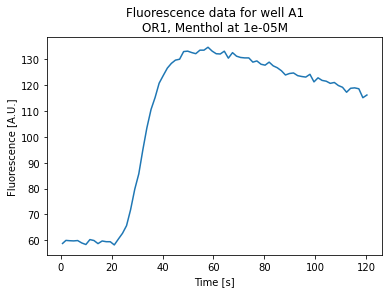

In [13]:
# Grab the data for a particular well
well = "A1"
time = time_df[well]
fluo = fluo_df[well]

plt.figure()
plt.plot(time, fluo)
plt.xlabel("Time [s]")
plt.ylabel("Fluorescence [A.U.]")
plt.title(f"Fluorescence data for well {well}\n"
        f"{plate_map.loc[well, 'OR']}, {plate_map.loc[well, 'VOC']} at {plate_map.loc[well, 'C']}M")


In [14]:
stim_time

19.0

### Write a function to compute the AUC on our data
The Area Under the Curve (AUC) is a common metric used to measure the level of activation of a protein to a particular compound. After subtracting the baseline, it is simply defined as the sum of a signal's after a stimulation times the width of the window:


<img src="ressources/AUC.png" width="600">

The stimulation can create a small artefact, we therefore only consider the fluorescence after a short time delay after the stimulation.

In [15]:
def compute_baseline(fluo, time, stim_time):
    "Compute the baseline for a fluorescence time series"
    is_before_stim = time < stim_time
    return fluo[is_before_stim].mean()

def auc(fluo, time, stim_time, delay_after_stim=0.):
    """Compute the AUC for a fluorescence  time series.
    
    Parameters
    ----------
    fluo, array
        The fluorescence data
    
    time, array
        The associated timestamps (same length as fluo)
    
    stim_time, float
        The stimulation time.
    
    delay_after_stim, float (default: 0.)
        A short time delay after the stimulation time that will be
        ignored when computing the AUC to avoid the stimulation artifact
        to have an effect on the result. 
    
    Returns
    -------
    float,
        The area under the curve
    
    """
    baseline = compute_baseline(fluo, time, stim_time)
    fluo_minus_baseline = fluo - baseline
    # Sum the fluorescence after the stimulation time
    # adding an extra time delay
    is_after_stim = time > stim_time + delay_after_stim
    summed_fluo = fluo_minus_baseline[is_after_stim].sum()
    # width of the interval in seconds
    width = time[-1] - time[is_after_stim][0]
    # Return the auc
    return width * summed_fluo

In [16]:
well = "A1"
time = time_df[well].values
fluo = fluo_df[well].values

compute_baseline(fluo, time, stim_time=stim_time)

59.48091666666667

In [17]:
auc(fluo, time, stim_time=stim_time, delay_after_stim=1.)

370390.7336447999

## Computation of the AUC for all wells
Add a column corresponding to the AUC in the DataFrame created from the plate map file

In [18]:
plate_map["AUC"] = 0.

for well in plate_map.index:
    time = time_df[well].values
    fluo = fluo_df[well].values
    plate_map.loc[well, "AUC"] = auc(fluo, time, stim_time=stim_time, delay_after_stim=1.)
plate_map

,plate_row,plate_col,OR,VOC,C,AUC
A1,A,1,OR1,Menthol,0.00001,370390.733645
A2,A,2,OR1,Menthol,0.00001,315984.220877
A3,A,3,OR1,Menthol,0.00001,318452.507290
A4,A,4,OR1,Menthol,0.00001,340731.879322
A5,A,5,OR1,Pinene,0.00010,42297.757632
...,...,...,...,...,...,...
H8,H,8,OR1,Pinene,0.00000,36221.098121
H9,H,9,OR1,DMSO,0.00000,32457.621879
H10,H,10,OR1,DMSO,0.00000,33534.504209
H11,H,11,OR1,DMSO,0.00000,40162.868053


### Dose response
For each compound, plot the dose response curves (AUC versus concentration) associated with the corresponding columns of the 96-wells plate.

**Bonus** You can replace the individual traces for each compound by an average and error bars corresponding for instance to the standard deviation.

Text(0.5, 1.0, 'Dose response curve for compound Menthol')

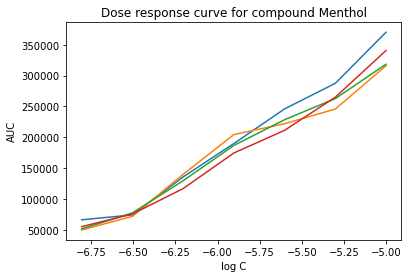

In [21]:
# Simple example for one compound
compound = "Menthol"
selected_data = plate_map[(plate_map.VOC == compound) & (plate_map.C != 0)]

plt.figure()

for plate_col in np.unique(selected_data.plate_col):
    selected_data_col = selected_data[selected_data.plate_col == plate_col]
    log_c = np.log10(selected_data_col.C)
    selected_auc = selected_data_col.AUC
    plt.plot(log_c, selected_auc)
plt.xlabel("log C")
plt.ylabel("AUC")
plt.title(f"Dose response curve for compound {compound}")

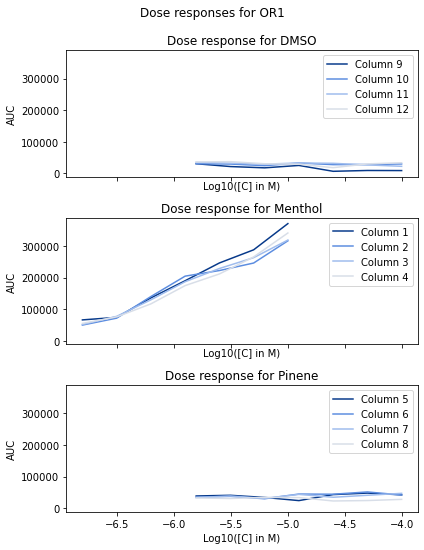

In [22]:
# Nicer plot if you wish:
# HEX code for the colors of the lines
colors = ["#07398a", "#5c8de0", "#9fbced", "#d8dee8"]

fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)
# Loop over the compounds
for i, compound in enumerate(np.unique(plate_map.VOC)):
    # Filter the data, here we simply discard the wells where the concentration is 0
    # N.B. We could instead plot the AUC divided by the AUC obtained for a concentration of 0
    selected_data = plate_map[(plate_map.VOC == compound) & (plate_map.C != 0)]
    
    selected_plate_columns = np.unique(selected_data.plate_col)
    ax = axs[i]  # Select the ax on which the data will be plotted
    for j, col in enumerate(selected_plate_columns):
        # Select the data to plot
        log_c = np.log10(selected_data[selected_data.plate_col == col].C)  # log concentration
        auc_to_plot = selected_data[selected_data.plate_col == col].AUC  # AUC
        # Plot the data
        ax.plot(log_c, auc_to_plot, label=f"Column {col}", c=colors[j])
        ax.legend()
        ax.set_title(f"Dose response for {compound}")
        ax.set_ylabel("AUC")

    ax.set_xlabel("Log10([C] in M)")
fig.suptitle(f"Dose responses for {plate_map.OR[0]}")
# Make the figure a bit nicer
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## To go further
**Bonus** Select an appropriate statistical test and use statsmodels to conclude on the activation of the olfactory receptor by menthol and pinene.

In [ ]:
import statsmodels